In [1]:
from os import listdir
from time import time

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import math
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from utils import auc, load_dataset, plot_roc, train
from einops import rearrange

<IPython.core.display.Javascript object>

In [2]:
from tensorflow.config import list_physical_devices

assert len(list_physical_devices("GPU"))

<IPython.core.display.Javascript object>

In [3]:
def schedule(epoch, lr) -> float:
    if epoch >= 200 and epoch % 25 == 0:
        lr = lr * math.exp(-0.1)
    return lr

<IPython.core.display.Javascript object>

In [4]:
scheduler = LearningRateScheduler(schedule)
es = EarlyStopping(monitor="loss", patience=5)
optimizer = Adam(lr=1e-2)

epochs = 1500
validation_freq = 2
# boundaries = [100, 300, 500, 1000, 2500, 5000]
fname = "model_2.h5"

<IPython.core.display.Javascript object>

In [7]:
X_train, y_train, X_test, y_test = load_dataset(f"MA0035_1000", labels="binlabels")

<IPython.core.display.Javascript object>

In [10]:
y_train.shape

(100000, 1)

<IPython.core.display.Javascript object>

-------------- Starting model_2 on boundary 1000 --------------
Epoch 1/1500
3125/3125 [==============================] - 47s 14ms/step - loss: 0.6950 - acc: 0.5006
Epoch 2/1500
3125/3125 [==============================] - 48s 15ms/step - loss: 0.6933 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/1500
3125/3125 [==============================] - 45s 14ms/step - loss: 0.6938 - acc: 0.4998
Epoch 4/1500
3125/3125 [==============================] - 48s 15ms/step - loss: 0.6934 - acc: 0.5013 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 5/1500
3125/3125 [==============================] - 46s 15ms/step - loss: 0.6934 - acc: 0.4977
Epoch 6/1500
3125/3125 [==============================] - 48s 15ms/step - loss: 0.6934 - acc: 0.4997 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 7/1500
3125/3125 [==============================] - 45s 14ms/step - loss: 0.6934 - acc: 0.4989


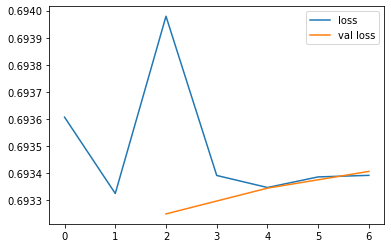

Training time: 5.47 minutes


ValueError: y should be a 1d array, got an array of shape (10000, 76, 1) instead.

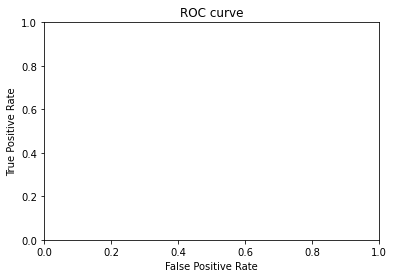

<IPython.core.display.Javascript object>

In [5]:
%%time
for n in [1, 2, 3, 5, 10]:
    print(f'-------------- Starting {fname.replace(".h5", "")} on boundary {n}000 --------------')
    model = load_model(f'../model_saves/eval_models/{fname}', compile=False)
    X_train, y_train, X_test, y_test = load_dataset(f'MA0035_{n}000', labels="binlabels")
    X_train = rearrange(X_train, "w h c -> w c h")
    X_test = rearrange(X_test, "w h c -> w c h")
    
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"])

    model = train(dataset=(X_train, y_train, X_test, y_test),
                  model=model,
                  epochs=epochs,
                  verbose=1,
                  validation_freq=validation_freq,
                  callbacks=[scheduler, es],
                 )

    plot_roc(y_test, model.predict(X_test), [0.5])
    for boundary in boundaries:
        print(f'Boundary: {boundary}\tAUC: {auc(y_test, model.predict(X_test), boundary):.5f}')

    model.save(f'../model_saves/evals/{fname.replace(".h5", "")}-{n}.h5')